# Jet Engine Remaining Useful Life Prediction

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
#import plot_helper as plt_hlp
#importlib.reload(plt_hlp); # so that I can use plot_helper without reloading the notebook kernel each time 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# from sklearn.feature_selection import f_regression
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing , HoltWintersResults
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics.pairwise import euclidean_distances

ModuleNotFoundError: No module named 'plot_helper'

# <font color='blue'>Data Exploration</font>

In [ ]:
# path to dataset 
dirname = os.getcwd()
data_pth = os.path.join(dirname, '0_raw_data','train_FD001.txt')

# column names for the dataset
# op_cond refers to operational condition, sn: sensor
col_name = ['engine', 'time', 'op_cond_1', 'op_cond_2', 'op_cond_3']
col_name = col_name + ['sn_{}'.format(s + 1) for s in range(21)]

In [4]:
# load data into sesnor df
# notice index_col=0 is used so that the data for each separate engine can be obtained easily
#(engine columns is just a group of data)
df = pd.read_csv(data_pth, header=None, names=col_name,delim_whitespace=True,index_col=0)

## Look at Values of Data Generally

In [5]:
df.head(5)

time  op_cond_1  op_cond_2  op_cond_3    sn_1    sn_2     sn_3  \
engine                                                                   
1          1    -0.0007    -0.0004      100.0  518.67  641.82  1589.70   
1          2     0.0019    -0.0003      100.0  518.67  642.15  1591.82   
1          3    -0.0043     0.0003      100.0  518.67  642.35  1587.99   
1          4     0.0007     0.0000      100.0  518.67  642.35  1582.79   
1          5    -0.0019    -0.0002      100.0  518.67  642.37  1582.85   

           sn_4   sn_5   sn_6  ...   sn_12    sn_13    sn_14   sn_15  sn_16  \
engine                         ...                                            
1       1400.60  14.62  21.61  ...  521.66  2388.02  8138.62  8.4195   0.03   
1       1403.14  14.62  21.61  ...  522.28  2388.07  8131.49  8.4318   0.03   
1       1404.20  14.62  21.61  ...  522.42  2388.03  8133.23  8.4178   0.03   
1       1401.87  14.62  21.61  ...  522.86  2388.08  8133.83  8.3682   0.03   
1       1406.22  14.62  21.61  ...  522.19  2388.04  8133.80  8.4294   0.03   

        sn_17  sn_18  sn_19  sn_20    sn_21  
engine                                       
1         392   2388  100.0  39.06  23.4190  
1         392   2388  100.0  39.00  23.4236  
1         390   2388  100.0  38.95  23.3442  
1         392   2388  100.0  38.88  23.3739  
1         393   2388  100.0  38.90  23.4044  

[5 rows x 25 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 1 to 100
Data columns (total 25 columns):
time         20631 non-null int64
op_cond_1    20631 non-null float64
op_cond_2    20631 non-null float64
op_cond_3    20631 non-null float64
sn_1         20631 non-null float64
sn_2         20631 non-null float64
sn_3         20631 non-null float64
sn_4         20631 non-null float64
sn_5         20631 non-null float64
sn_6         20631 non-null float64
sn_7         20631 non-null float64
sn_8         20631 non-null float64
sn_9         20631 non-null float64
sn_10        20631 non-null float64
sn_11        20631 non-null float64
sn_12        20631 non-null float64
sn_13        20631 non-null float64
sn_14        20631 non-null float64
sn_15        20631 non-null float64
sn_16        20631 non-null float64
sn_17        20631 non-null int64
sn_18        20631 non-null int64
sn_19        20631 non-null float64
sn_20        20631 non-null float64
sn_21        20631 non-null float64

**great no null values and all data columns are numeric!** 

In [7]:
df.describe()

time     op_cond_1     op_cond_2  op_cond_3          sn_1  \
count  20631.000000  20631.000000  20631.000000    20631.0  2.063100e+04   
mean     108.807862     -0.000009      0.000002      100.0  5.186700e+02   
std       68.880990      0.002187      0.000293        0.0  6.537152e-11   
min        1.000000     -0.008700     -0.000600      100.0  5.186700e+02   
25%       52.000000     -0.001500     -0.000200      100.0  5.186700e+02   
50%      104.000000      0.000000      0.000000      100.0  5.186700e+02   
75%      156.000000      0.001500      0.000300      100.0  5.186700e+02   
max      362.000000      0.008700      0.000600      100.0  5.186700e+02   

               sn_2          sn_3          sn_4          sn_5          sn_6  \
count  20631.000000  20631.000000  20631.000000  2.063100e+04  20631.000000   
mean     642.680934   1590.523119   1408.933782  1.462000e+01     21.609803   
std        0.500053      6.131150      9.000605  3.394700e-12      0.001389   
min      641.210000   1571.040000   1382.250000  1.462000e+01     21.600000   
25%      642.325000   1586.260000   1402.360000  1.462000e+01     21.610000   
50%      642.640000   1590.100000   1408.040000  1.462000e+01     21.610000   
75%      643.000000   1594.380000   1414.555000  1.462000e+01     21.610000   
max      644.530000   1616.910000   1441.490000  1.462000e+01     21.610000   

       ...         sn_12         sn_13         sn_14         sn_15  \
count  ...  20631.000000  20631.000000  20631.000000  20631.000000   
mean   ...    521.413470   2388.096152   8143.752722      8.442146   
std    ...      0.737553      0.071919     19.076176      0.037505   
min    ...    518.690000   2387.880000   8099.940000      8.324900   
25%    ...    520.960000   2388.040000   8133.245000      8.414900   
50%    ...    521.480000   2388.090000   8140.540000      8.438900   
75%    ...    521.950000   2388.140000   8148.310000      8.465600   
max    ...    523.380000   2388.560000   8293.720000      8.584800   

              sn_16         sn_17    sn_18    sn_19         sn_20  \
count  2.063100e+04  20631.000000  20631.0  20631.0  20631.000000   
mean   3.000000e-02    393.210654   2388.0    100.0     38.816271   
std    1.556432e-14      1.548763      0.0      0.0      0.180746   
min    3.000000e-02    388.000000   2388.0    100.0     38.140000   
25%    3.000000e-02    392.000000   2388.0    100.0     38.700000   
50%    3.000000e-02    393.000000   2388.0    100.0     38.830000   
75%    3.000000e-02    394.000000   2388.0    100.0     38.950000   
max    3.000000e-02    400.000000   2388.0    100.0     39.430000   

              sn_21  
count  20631.000000  
mean      23.289705  
std        0.108251  
min       22.894200  
25%       23.221800  
50%       23.297900  
75%       23.366800  
max       23.618400  

[8 rows x 25 columns]

In [8]:
sns.set() 

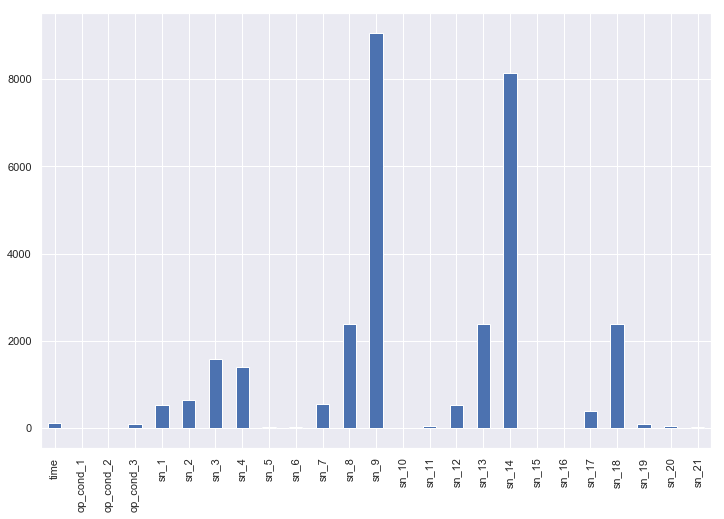

In [9]:
# look at the mean of all columns
df.mean().plot.bar(figsize=(12,8));

In [10]:
# mean for engine num=5
sn_df.loc[5].mean().plot.bar(figsize=(12,8));

NameError: name 'sn_df' is not defined

## Examine Correlation Between Columns

In [11]:
engine_num=5
corr_all=df.drop('time',axis=1).corr()# linear correlation between variables for all engines
corr_num=df.loc[engine_num].drop('time',axis=1).corr() # linear correlation between variables for engine [engine_num]

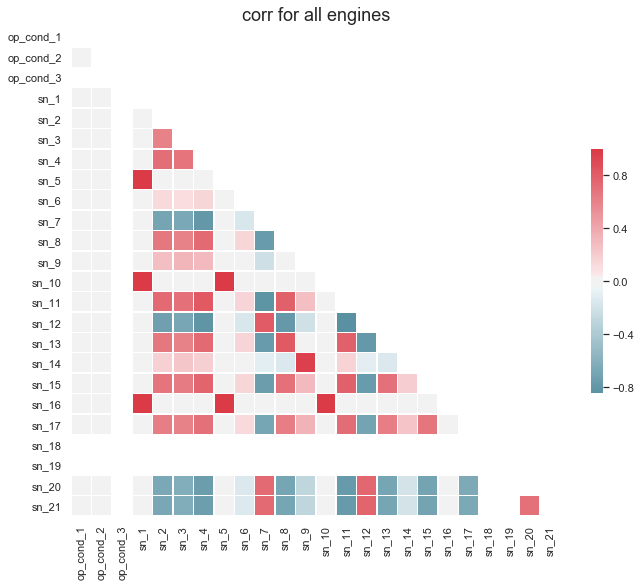

In [20]:
f=plt_hlp.plot_corr(corr_all,diag_flag=True , title='corr for all engines')

In [21]:
f.savefig('Meduim_images/corr_all.png', format='png', dpi=600)

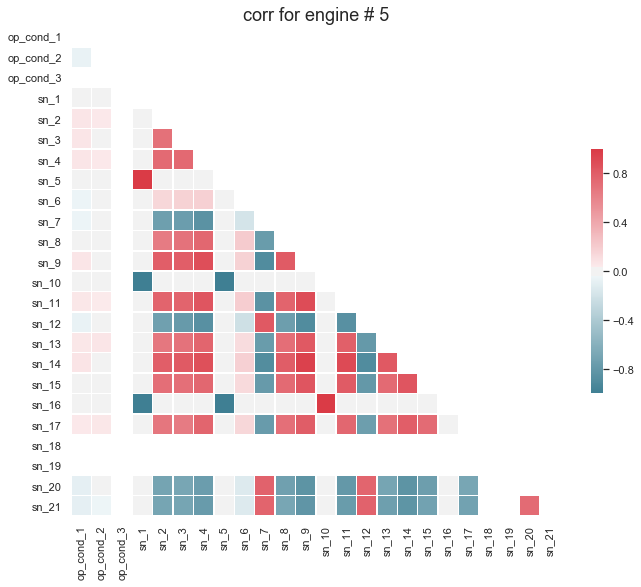

In [22]:
f=plt_hlp.plot_corr(corr_num,diag_flag=True , title='corr for engine # {}'.format(engine_num))

In [23]:
f.savefig('Meduim_images/corr_5.png', format='png', dpi=600)

from the first look, it seems that some sensors are very correlated with each other. this seems to hold for all engine together and a single-engine data as well. this might cause issues during modeling and I might need to delete/fuse some sensor data. 

also, it seems that some columns need to be removed since they are all white. this might indicate non-changing values
let's look at the correlation deeper 

### Find high correlation pairs

In [24]:
def find_corr_pairs(corr,thrsh):
    
    """
    find high correlation column pairs in df 
    ======================================
    input: 
    corr - (df)- correlation matrix generated by pandas
    thrsh - (float) threshold value to consider correlation as high so that it is included in the output 
    output:
    high_corr_pairs - (list) list of tuples of the two-column names and their correlation. corr> thrsh
    """
    high_corr_pairs = []
    # same as input 'corr' but the upper -triangle half of the matrix is zeros ( for convenience only) 
    corr_diag = pd.DataFrame(np.tril(corr.values), columns=corr.columns, index = corr.index)

    # check  the correlation between every pair of columns in the corr and keeps the high ones
    for col_num , col in enumerate(corr_diag):
        col_corr=corr_diag[col].iloc[col_num+1:] # this slicing ensures ignoring self_corr and duplicates due to symmetry
        # bool mask for pairs with high corr with col
        mask_pairs = col_corr.apply(lambda x: abs(x))>thrsh 
        idx_pairs=col_corr[mask_pairs].index

        # create list of high corr pairs
        for idx , corr in zip(idx_pairs,col_corr[mask_pairs].values):
            high_corr_pairs.append((col, idx, corr))
    
    return high_corr_pairs 

    

In [25]:
corr_pairs=find_corr_pairs(corr_all,0.9)
for c in corr_pairs:
    print(c)


('sn_1', 'sn_5', 1.0)
('sn_1', 'sn_10', 1.0)
('sn_1', 'sn_16', 1.0)
('sn_5', 'sn_10', 1.0)
('sn_5', 'sn_16', 1.0)
('sn_9', 'sn_14', 0.9631566003059564)
('sn_10', 'sn_16', 1.0)


the above sensors are prefectly correlated with each others. which means that I can remove some columns for the analysis

now let's look at the time series plot and distribution of various data columns

### plot variables distribution

In [30]:
def plot_dist(df, engine_num=None):
    '''plot all non trivial measurements and states'''
    
    cols = df.columns
    n_cols = min(len(cols), 5)
    n_rows = int(np.ceil(len(cols) / n_cols))
    
    sns.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,12))
    axes = axes.flatten()
    if engine_num != None: 
        fig.suptitle('distributions for engine #: {}'.format(engine_num))
        df_plot = df.loc[engine_num]
    else: 
        fig.suptitle('distributions for all engines')
        df_plot = df
    for col, ax in zip(cols, axes):
        ax=sns.distplot(df_plot[col], ax=ax, label=col)
        ax.legend(loc=1)
#         labels(col, "p", ax)
    return fig

C:\Users\SMART\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\SMART\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


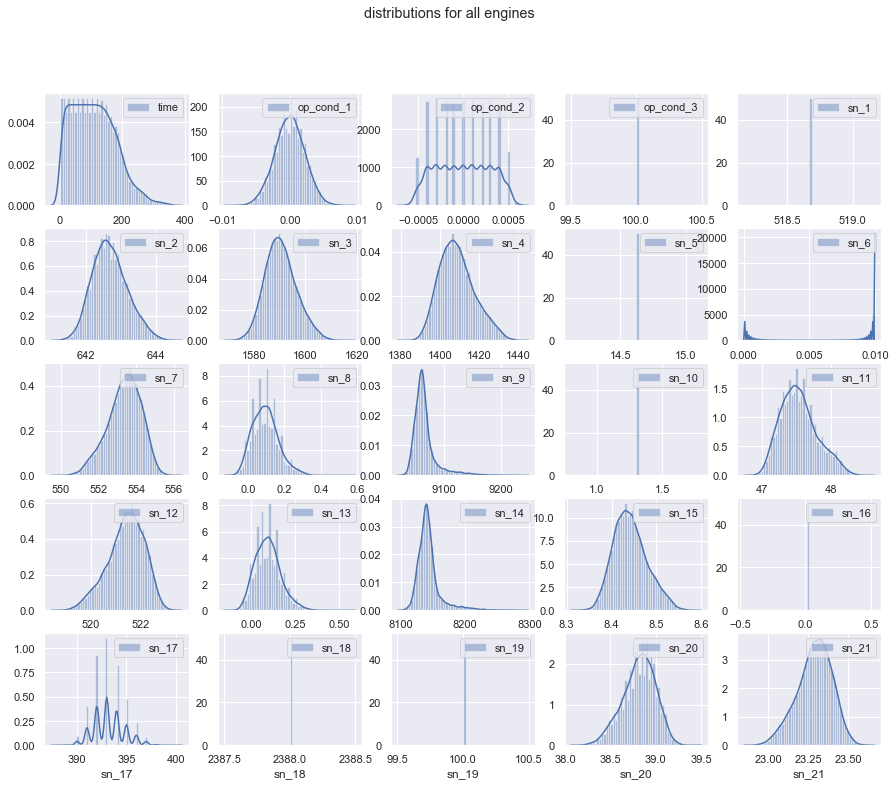

In [31]:
fig=plot_dist(df)

In [32]:
fig.savefig('Meduim_images/dist_all.png', format='png', dpi=600)

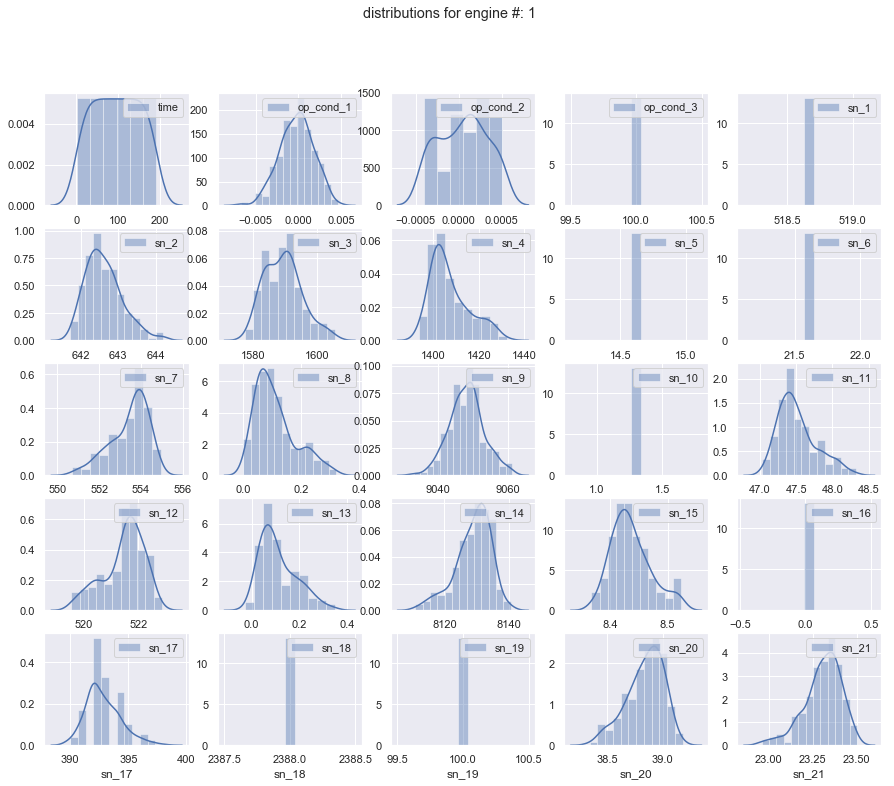

In [33]:
fig=plot_dist(df,1)

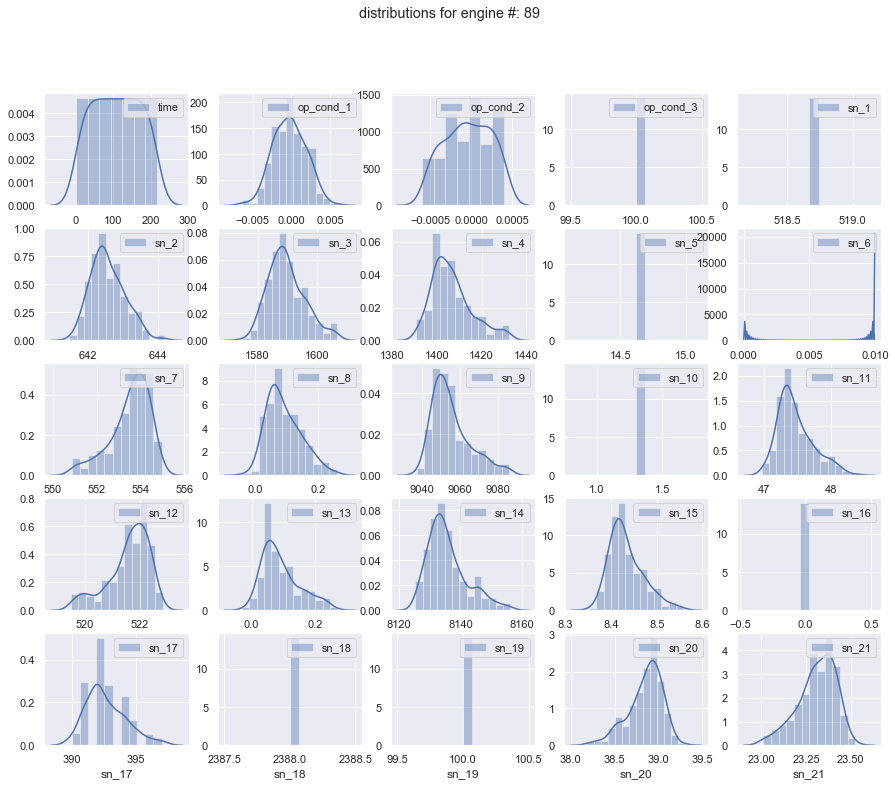

In [34]:
fig=plot_dist(df,89)

In [35]:
fig.savefig('Meduim_images/dist_89.png', format='png', dpi=600)

### remove columns that do not change with time ( Data Prep) 

In [36]:
col_remove=[ col for col in df.columns if (df[col].std() <= .0001*df[col].mean()) & (df[col].nunique() <=4)  ]

print('columns to be removed from analysis since they do not change with time \n',col_remove)

columns to be removed from analysis since they do not change with time 
 ['op_cond_3', 'sn_1', 'sn_5', 'sn_6', 'sn_10', 'sn_16', 'sn_18', 'sn_19']


In [37]:
df.drop(columns=col_remove,axis=1,inplace=True)

let's look at the high correlation columns right now agian 

In [38]:
engine_num=17
thrsh=.9
corr_all=df.drop('time',axis=1).corr()# linear correlation between variables for all engines
corr_num=df.loc[engine_num].drop('time',axis=1).corr() # linear correlation between variables for engine [engine_num]


In [39]:
corr_pairs=find_corr_pairs(corr_all,thrsh)
print('high correlation columns all engines:')
for c in corr_pairs:
    print(c)

    

high correlation columns all engines:
('sn_9', 'sn_14', 0.9631566003059564)


In [40]:
corr_pairs=find_corr_pairs(corr_num,thrsh)
print('high correlation columns engine # {}:'.format(engine_num))
for c in corr_pairs:
    print(c)

high correlation columns engine # 17:
('sn_9', 'sn_11', 0.9036437896879275)
('sn_9', 'sn_12', -0.9000742949811593)
('sn_9', 'sn_14', 0.9829117696117363)
('sn_11', 'sn_14', 0.9053787127230819)


In [41]:
corr_pairs=find_corr_pairs(corr_num,thrsh)
print('high correlation columns engine # {}:'.format(engine_num))
for c in corr_pairs:
    print(c)

high correlation columns engine # 17:
('sn_9', 'sn_11', 0.9036437896879275)
('sn_9', 'sn_12', -0.9000742949811593)
('sn_9', 'sn_14', 0.9829117696117363)
('sn_11', 'sn_14', 0.9053787127230819)


In [42]:
corr_pairs=find_corr_pairs(corr_num,thrsh)
print('high correlation columns engine # {}:'.format(engine_num))
for c in corr_pairs:
    print(c)

high correlation columns engine # 17:
('sn_9', 'sn_11', 0.9036437896879275)
('sn_9', 'sn_12', -0.9000742949811593)
('sn_9', 'sn_14', 0.9829117696117363)
('sn_11', 'sn_14', 0.9053787127230819)


it seems from above that only sensors [ 9 , 11 , 12 , 14 ] are highly correlated

actually only [9 , 14] are highly correlated when considering the data for all engines

### pair plots for all engines

In [43]:
def plot_pair(df,idx1,idx2,engine_num=None):
    """
    plot simple pair plots for a df between columns [idx1,idx2]
    ===========================================================
    input: 
    df - (df)- Dataframe to plot the pairs for 
    idx1,2 - (int) columns index to plot [idx1:idx2] 
    engine_num - (int) engine number to selector 
    """  
    sns.set()
    cols = df.iloc[:,idx1:idx2].columns.values.tolist()
    
    if engine_num == None: 
        df_pair_plot = df.iloc[:,idx1:idx2]
        print('plotting pairs for all engines and columns: {}'.format(cols))
        sns.pairplot(df_pair_plot,diag_kind = 'kde',height=2.5);
    else:
        df_pair_plot = df.loc[engine_num].iloc[:,idx1:idx2]
        sns.pairplot(df_pair_plot,diag_kind = 'kde',height=2.5);
        print('plotting pairs for engine {} and columns: {}'.format(engine_num,cols))
    

plotting pairs for all engines and columns: ['op_cond_1', 'op_cond_2', 'sn_2', 'sn_3']


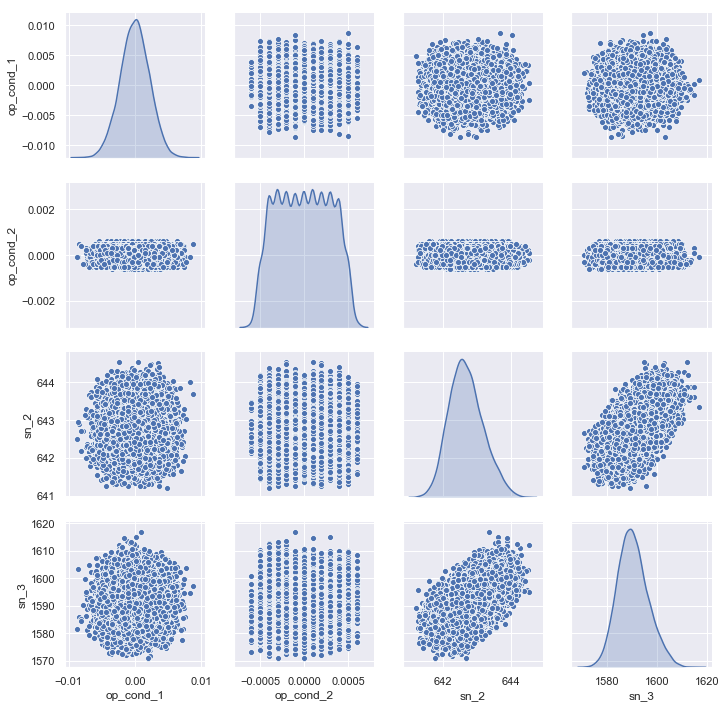

In [44]:
idx1 = 1
idx2 = 5
plot_pair(df,idx1,idx2,engine_num=None)


plotting pairs for all engines and columns: ['sn_7', 'sn_8', 'sn_9', 'sn_11']


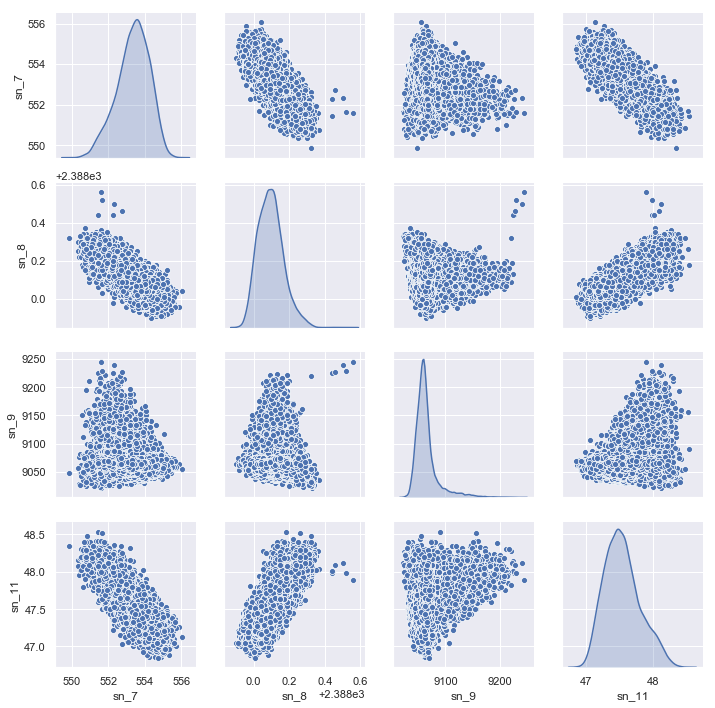

In [45]:
idx1 = 6
idx2 = 10
plot_pair(df,idx1,idx2,engine_num=None)

plotting pairs for all engines and columns: ['sn_13', 'sn_14', 'sn_15', 'sn_17']


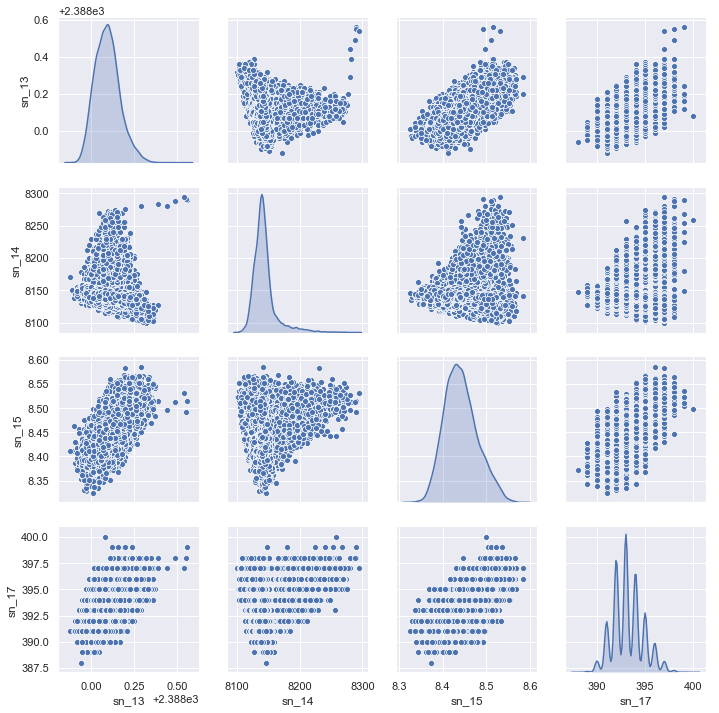

In [46]:
idx1 = 11
idx2 = 15
plot_pair(df,idx1,idx2,engine_num=None)

### pair plots for one engine

plotting pairs for engine 5 and columns: ['op_cond_1', 'op_cond_2', 'sn_2', 'sn_3']


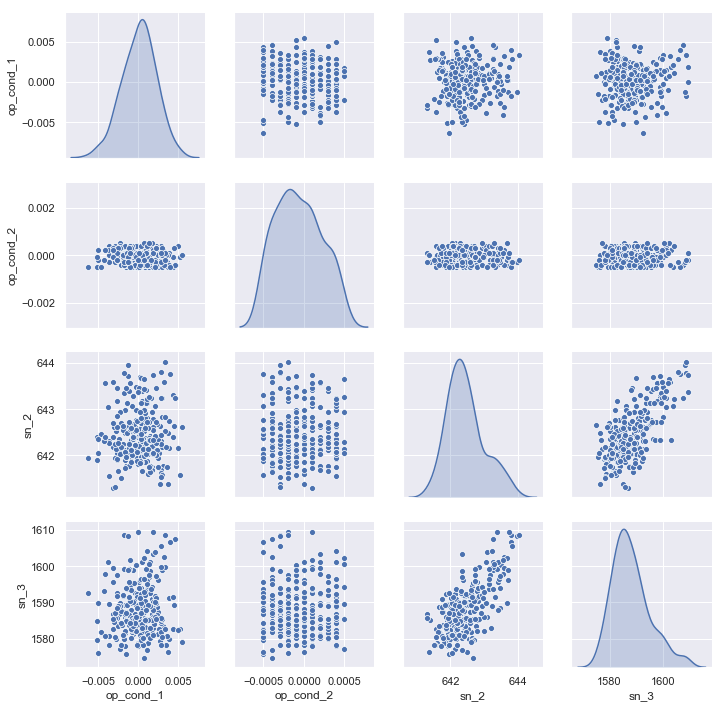

In [47]:
idx1 = 1
idx2 = 5
engine_num = 5
plot_pair(df,idx1,idx2,engine_num)

plotting pairs for engine 5 and columns: ['sn_7', 'sn_8', 'sn_9', 'sn_11']


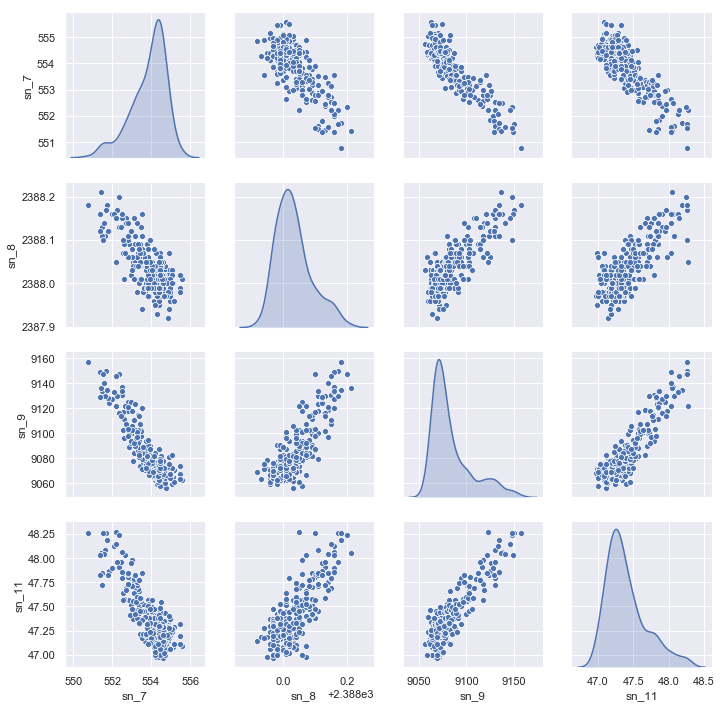

In [48]:
idx1 = 6
idx2 = 10
engine_num = 5
plot_pair(df,idx1,idx2,engine_num)

plotting pairs for engine 5 and columns: ['sn_13', 'sn_14', 'sn_15', 'sn_17']


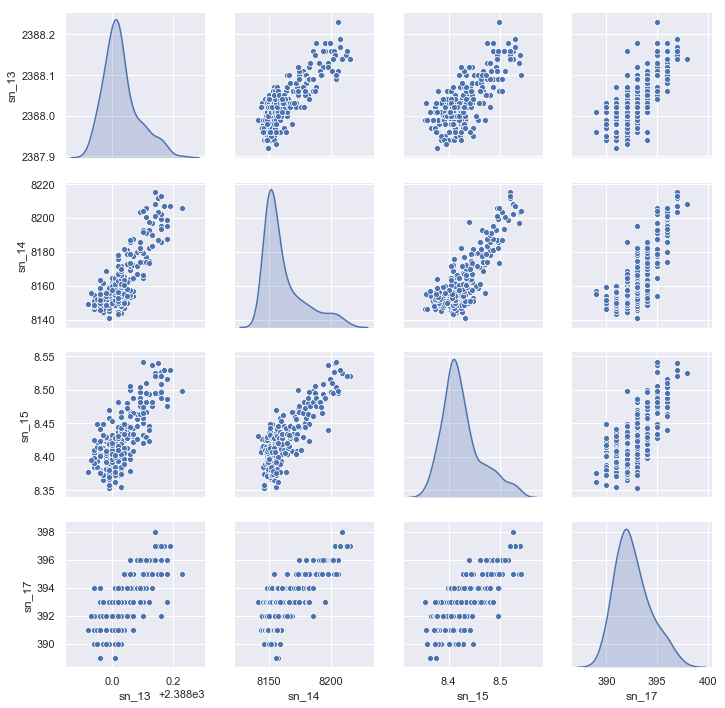

In [49]:
idx1 = 11
idx2 = 15
engine_num = 5
plot_pair(df,idx1,idx2,engine_num)

from above pair plots, main takeaways:
1. the distribution of almost all variables is single skewed gaussian
2. op_cond_2 and sn_17 seem to be discrete variables and not continuous ( maybe these need to be deleted to keep only continuously varying variables for modeling)
3. the observations above holds when plotting all engines and when the plot is made for a specific engine. (means all engine are very similar in their output response)

### time series plotting 

In [50]:
def plot_ts(df, engine_num=1):
    """
    plot time history of for specific engine 
    ========================================
    input: 
    df - (df) Dataframe you whish to plot the time series for its columns
    engine_num - (int) engine number to selector  
    """
    
    # prepare the dataframe for plotting
    ts = df.loc[engine_num].copy() # df for the needed engine
    time = ts['time']
    ts.drop(labels=['time'],axis=1,inplace=True)
    cols = ts.columns
    
    # plotting
    fig, axes = plt.subplots(len(cols), 1, figsize=(19,17))
    for col, ax in zip(cols, axes):
        ax.plot(time,ts[col],label=col)
        ax.legend(loc=2)
        
    # figure title    
    fig.suptitle('Engine #: {}'.format(engine_num))

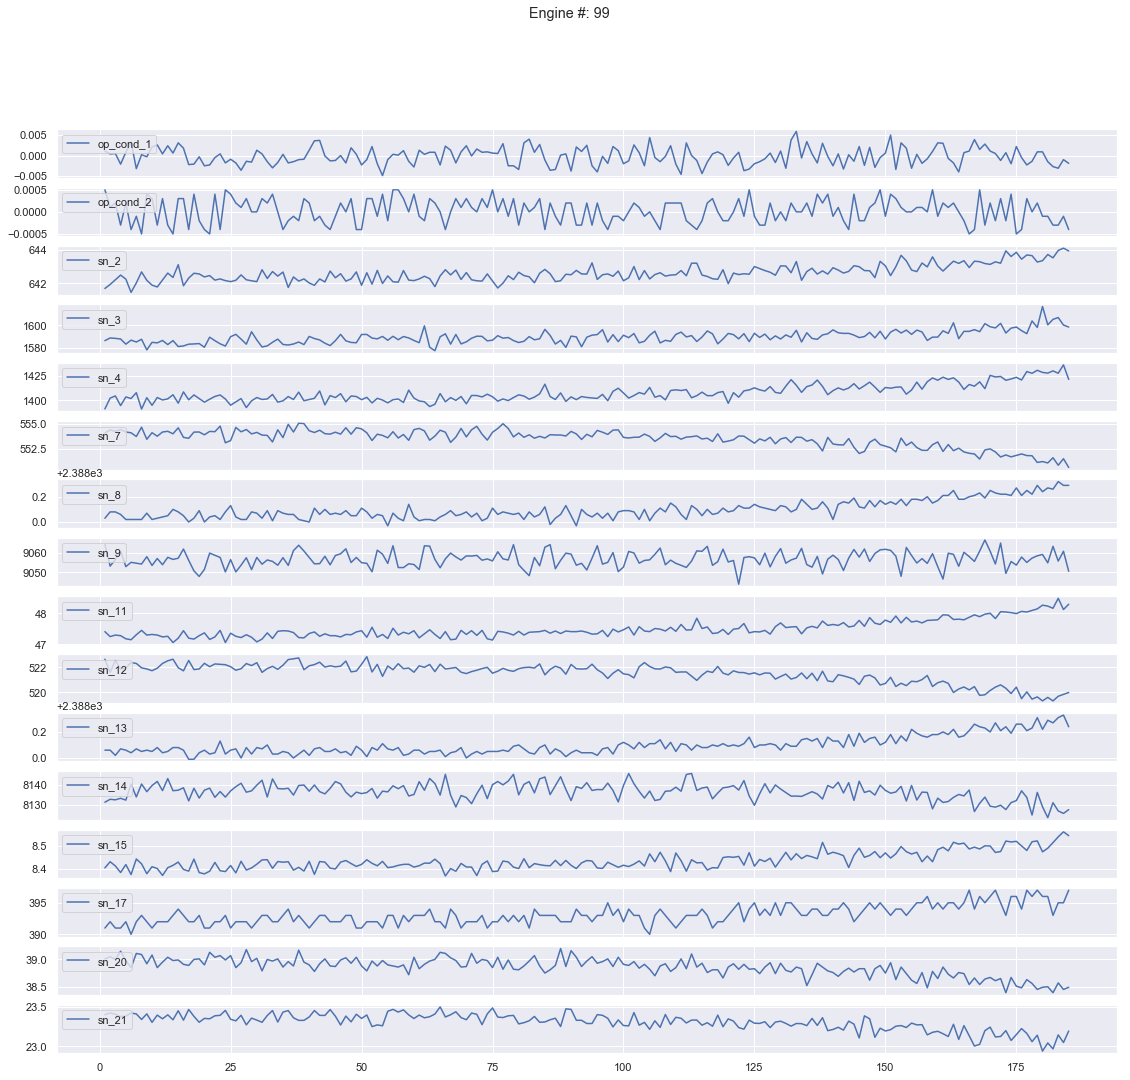

In [51]:
plot_ts(df, 99)

### Calculate RUL at each time instance and add it to df

In [52]:
# add RUL to each engine based on time column, 
# notice that RUL is negative quantity here to make 0 as the end of life for all engines
for id in df.index.unique():
    df.loc[id,'RUL'] = df.loc[id]['time'].apply(lambda x: x-df.loc[id]['time'].max())

In [55]:
def plot_ts_all(df):
    """
    plot time history of for all engines in the data
    =================================================
    input: 
    df - (df) Dataframe you whish to plot the time series for its columns
    """
    
    # prepare the dataframe for plotting
    ts = df.copy() # df for the needed engine
    ts.drop(labels=['time'],axis=1,inplace=True)
    
    cols = ts.columns
    # plotting
    fig, axes = plt.subplots(len(cols)-1, 1, figsize=(19,17))
    for col, ax in zip(cols, axes):
        if col == 'RUL':
            continue
            
        fontdict = {'fontsize': 14}
        ax.set_title(col,loc='left',fontdict=fontdict)
        for engine_id in ts.index.unique():
            time = ts.loc[engine_id,'RUL']
            ax.plot(time,ts.loc[engine_id,col],label=col)
            
        
        
    # figure title    
    fig.suptitle('All Engines Time Series \n each line is different engine resposne\n x-axis is RUL with the rightmost point\
    being the last cycle for all engines')
    return fig

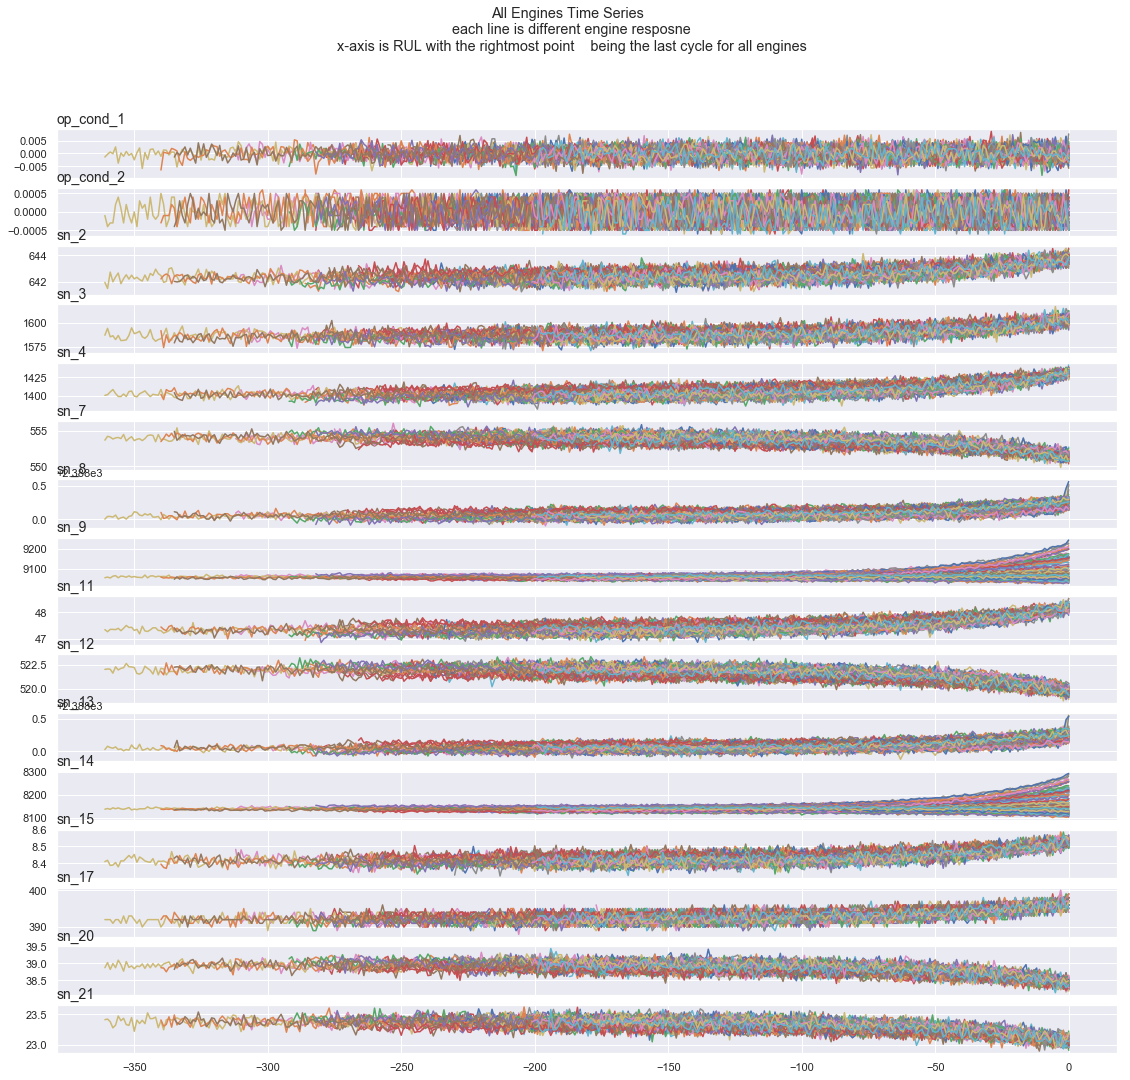

In [56]:
fig=plot_ts_all(df)

In [57]:
fig.savefig('Meduim_images/ts_all.png', format='png', dpi=600)

From the time series plot of all engine, we can find the below takeaways 

1. columns [op_cond_1, op_cond_2] do not have an apparent trend toward the end life of the engine. they are just random noise. so with great confidence, I can say that these two columns cannot help a predicitive model that is based on the trend of the series to discover relevant information regarding estimating the RUL 
2. columns [sn_9 , sn_14] indicates that the trend depends on the specific engine. some engines at the end of life tend to increase in these two columns while others tend to decrease. what is common about these two sensors is that the magnitude at the end life gets amplified. 
3. it is good to see that all other columns show an apparent trend as the fault propagate throughout the engine cycles and cause them to fail. [ this helps the model that will try to use the data to predict RUL :) ]

# <font color='blue'>Methodology</font>

## Data Preprocessing

### Remove columns with no apparent trend  ( Data Prep) 

In [58]:
df.drop(['op_cond_1','op_cond_2' , 'sn_9' , 'sn_14'],axis=1,inplace=True)

In [59]:
df.shape

(20631, 14)

### standardized the remaining columns

In [60]:
# get all sensors
raw_columns = df.columns.values[1:-1]
raw_sensors = df[raw_columns].values # as numpy array

In [61]:
raw_columns

array(['sn_2', 'sn_3', 'sn_4', 'sn_7', 'sn_8', 'sn_11', 'sn_12', 'sn_13',
       'sn_15', 'sn_17', 'sn_20', 'sn_21'], dtype=object)

In [64]:
print('sensors remaining for analysis after considering trends in the time series plot \n{}'.format(raw_columns))

sensors remaining for analysis after considering trends in the time series plot 
['sn_2' 'sn_3' 'sn_4' 'sn_7' 'sn_8' 'sn_11' 'sn_12' 'sn_13' 'sn_15'
 'sn_17' 'sn_20' 'sn_21']


In [65]:
standard_scale = StandardScaler()
standard_sensors = standard_scale.fit_transform(raw_sensors)

### fit linear regression to the sensor data to get the slopes 

In [66]:
lin_model =LinearRegression()


In [67]:
engine_num=3
x = df.loc[engine_num,'RUL'].values

In [68]:
row_name=df.loc[engine_num].iloc[-1].name

In [69]:
row_sl=df.index.get_loc(row_name) # row slice to get numpy index 

In [70]:
y=standard_sensors[row_sl] # sensor values for the specifc engine

In [71]:
x.reshape(-1, 1).shape

(179, 1)

In [72]:
x.shape

(179,)

In [73]:
lin_model.fit(x.reshape(-1, 1),y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [74]:
lin_model.coef_[:,0].shape

(12,)

In [75]:
lin_model.score(x.reshape(-1, 1),y)

0.5115128307379359

In [76]:
y_hat = lin_model.predict(x.reshape(-1, 1))

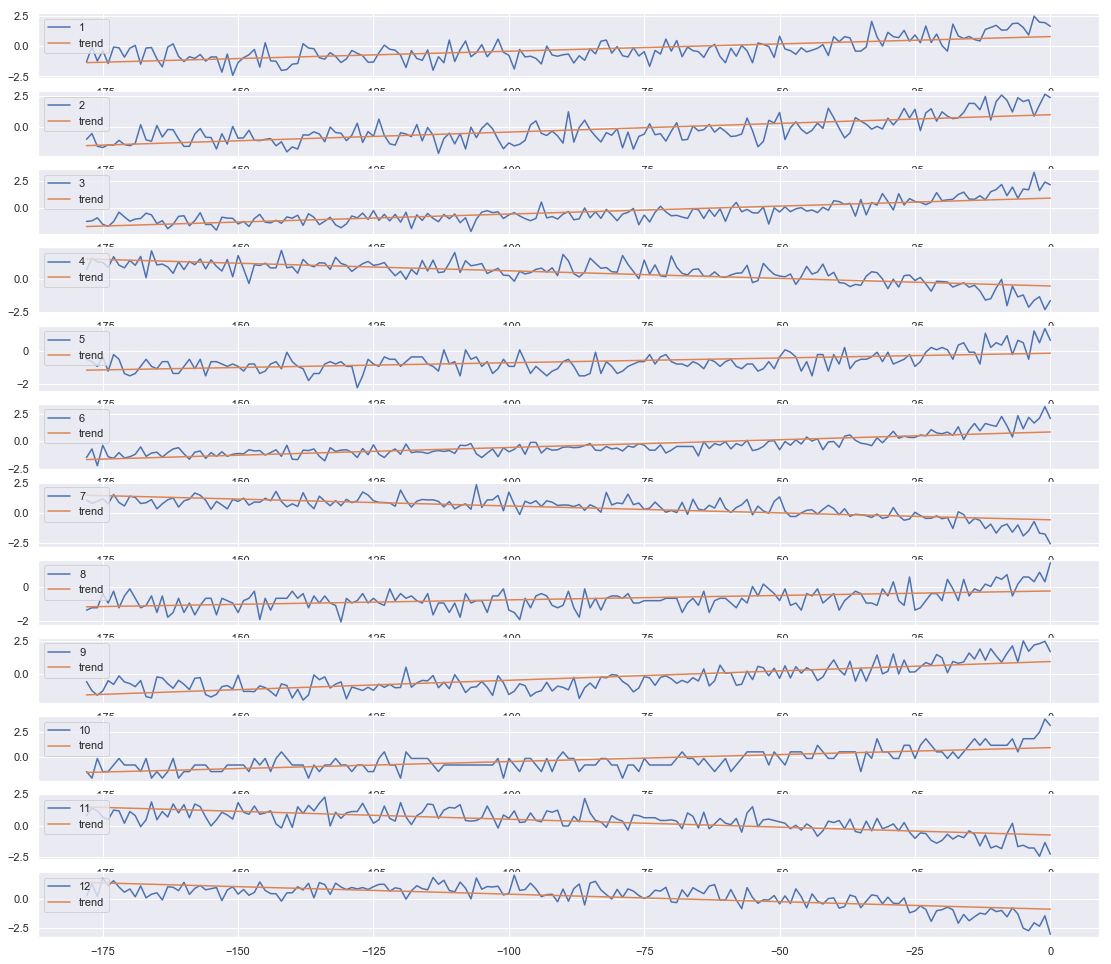

In [79]:
# plotting
time = df.loc[engine_num,'RUL']
cols = df.columns[1:-1]
fig, axes = plt.subplots(len(cols), 1, figsize=(19,17))
for col, ax in zip(range(standard_sensors.shape[1]), axes):
    ax.plot(time,standard_sensors[row_sl,col],label=col+1)
    ax.plot(time,y_hat[:,col],label='trend')
    ax.legend(loc=2)

In [88]:
fig.savefig('Meduim_images/lin_trend.png', format='png', dpi=600)

In [80]:
def lin_slopes(sensors,df,engine_num):
    """
    gives slopes of a teh tred lines for each sesnor 
    =================================================
    input: 
    sensors - (ndarray) numpy array of standardized signals ( rows: -RUL columns, various signals)
    engine_num - (int) engine number to selector
    df - (df) data frame of data
    output: 
    slopes -(ndarray) numpy array of slopes rows: slope of each signal linear trend line
    """
    model = LinearRegression()
    x = df.loc[engine_num,'RUL'].values
    row_name=df.loc[engine_num].iloc[-1].name
    row_sl=df.index.get_loc(row_name) # row slice to get numpy index 
    y=sensors[row_sl] # sensor values for the specifc engine
    model.fit(x.reshape(-1, 1),y)
    slopes=model.coef_[:,0]
    return slopes
    

In [82]:
# finding slopes for all engines
engines=df.index.unique().values
slopes = np.empty((standard_sensors.shape[1],len(engines)))
for i,engine in enumerate(engines):
    slopes[:,i] = lin_slopes(standard_sensors,df,engine) 

In [83]:
# creating slopes_df
slopes_df = pd.DataFrame(slopes.T,index=engines,columns =raw_columns )


In [84]:
slopes_df.describe()

sn_2        sn_3        sn_4        sn_7        sn_8       sn_11  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.010975    0.010625    0.012324   -0.011917    0.010246    0.012641   
std      0.002842    0.002459    0.003010    0.003444    0.005552    0.003387   
min      0.005116    0.005192    0.007006   -0.020537    0.000914    0.006454   
25%      0.009114    0.008862    0.010195   -0.013892    0.006127    0.010143   
50%      0.010601    0.010617    0.012143   -0.011197    0.009827    0.012485   
75%      0.012328    0.012220    0.013796   -0.009588    0.014121    0.014375   
max      0.018116    0.016361    0.019765   -0.005189    0.022287    0.021425   

            sn_12       sn_13       sn_15       sn_17       sn_20       sn_21  
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000  
mean    -0.012249    0.010271    0.011670    0.010988   -0.011533   -0.011540  
std      0.003736    0.005540    0.002884    0.002383    0.002899    0.002842  
min     -0.022150    0.000765    0.006841    0.006122   -0.019988   -0.019546  
25%     -0.014874    0.006001    0.009384    0.009305   -0.013105   -0.013138  
50%     -0.011462    0.009734    0.011378    0.010961   -0.011151   -0.011283  
75%     -0.009409    0.013808    0.013416    0.012324   -0.009329   -0.009657  
max     -0.005428    0.023741    0.019327    0.016854   -0.006681   -0.005770

In [85]:
# index of highest to lowest abs(slope) for each signal 
slope_order_idx=np.argsort(np.abs(slopes.mean(axis=1)))[::-1]

In [86]:
slope_order_idx

array([ 5,  2,  6,  3,  8, 11, 10,  9,  0,  1,  7,  4], dtype=int64)

In [87]:
print('the order of trend slope magnitude is \n{}'.format(raw_columns[slope_order_idx]))

the order of trend slope magnitude is 
['sn_11' 'sn_4' 'sn_12' 'sn_7' 'sn_15' 'sn_21' 'sn_20' 'sn_17' 'sn_2'
 'sn_3' 'sn_13' 'sn_8']


### PCA with all sensors

In [89]:
pca = PCA()
pca.fit(standard_sensors)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [95]:
100*pca.explained_variance_ratio_

array([74.02229299,  4.09808175,  3.35440958,  3.02407954,  2.79358664,
        2.54795856,  2.39672973,  1.91627556,  1.70348529,  1.47228614,
        1.43837368,  1.23244054])

### PCA with highest 6 sensors in terms of linear trend slope

In [96]:
num_high_slopes = 6
pca_high_n_components=3
sensors_high_trend=standard_sensors[:,slope_order_idx[0:num_high_slopes]]
pca_high = PCA(pca_high_n_components,whiten=True)
pca_high.fit(sensors_high_trend)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [97]:
pca_high.explained_variance_ratio_

array([0.81660323, 0.04968993, 0.0442961 ])

In [98]:
sensors_pca=pca_high.transform(sensors_high_trend)

In [99]:
sensors_pca.shape

(20631, 3)

based on the analysis of linear trend, the top 6 sensors are chosen based on the magnitude of their linear trend, i.e. the magnitude of their linear regression slope. it looks that based on these 6 sensors, taking 3 first principle components s captures about 90% of the data variability. hence the further reduction in dimensionality comes at a low loss of information. 

the conclusion  from the above ( data exploration and processing) steps are the following: 

1. the sensors that do not change with time ( do not have variation with engine operational cycles) are dropped since they do not offer any information toward prediction the end of life
2. the sensors that do not have apparent trend (looks like noise only, or do not have a trend toward the end of life) are dropped as well. this contains the sensors that behave differently for different engines ( since these will confuse the learning algorithm and can cause large testing errors since their behavior are not universal concerning all engines)
3. based on linear regression of the remain sensor data with RUL, the highest 6 sensors in terms of the absolute values of the slopes are kept only. these sensors change predictably at the end of life for the engines.
4. further, reduce the dimensionality  by taking the first 3 principal components for the data 


the remaining 3  components of the data will be fused to make a Health Index (HI) function with RUL for each engine 

# <font color='blue'>Implementation</font>

In [100]:
# create a dictionary with engine slices 

engines=df.index.unique().values # engine numbers
engine_slices = dict()# key is engine number, value is a slice that gives numpy index for the data that pertains to an engine  

for i,engine_num in enumerate(engines):
    row_name=df.loc[engine_num].iloc[-1].name
    row_sl=df.index.get_loc(row_name) # row slice to get numpy index 
    engine_slices[engine_num]=row_sl


In [101]:
# create RUL vector
RUL = np.empty(len(engines))

for i,engine_num in enumerate(engines):
    RUL[i]=-1*df.loc[engine_num]['RUL'].min()


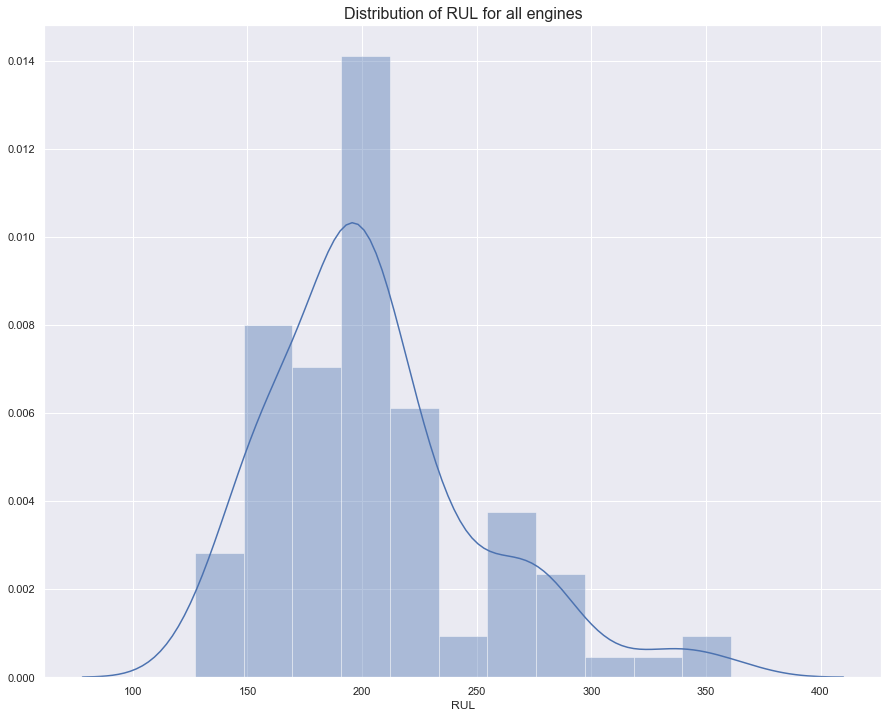

In [102]:
# ax = plt.subplot(figsize=(15,12))
fig=plt.figure(figsize=(15,12))
ax=sns.distplot(RUL)
ax.set_title('Distribution of RUL for all engines',{'fontsize':16});
ax.set_xlabel('RUL');




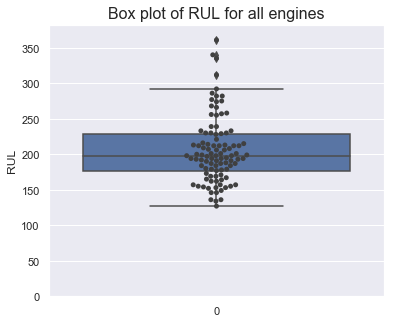

In [103]:
fig=plt.figure(figsize=(6,5))
ax=sns.distplot(RUL)
ax.set_title('Box plot of RUL for all engines',{'fontsize':16});
ax.set_ylabel('RUL');
ax = sns.boxplot( data=RUL)
ax = sns.swarmplot( data=RUL, color=".25")

In [812]:
(RUL>350).sum()

1

**to create a fused health index (HI) sensor, first, we need to train the extreme data ( data at the beginning of the engine cycle and at the end of engine cycle life ). beginning of life gets values of 1, while the end of life gets values of 0. 
so the model takes the sensor values and finds a fused signal that gives the health indication HI**

I'll call engine with prefect health as the one which has (RUL_hgih) or more cycles until its failures. zero health is considered as the last (RUL_low) cycles of each engine operation

### Fuse sensor data to get health index

In [104]:
# conditions and thersholds for high HI and low HI
RUL_high = 300 # threshold of number of cycles that makes us consider the engine started at perfect health 
RUL_low = 5  # threshold of the number of cycles below which engine is considered has failed l ( for purposes of modeling and getting data)  
RUL_df = df['RUL'].values


In [105]:
# Gather data and prepare it for HI fusing and modeling


# find engines with high (low) HI at their initial (final) cycles
idx_high_HI = [RUL_df<=-RUL_high][0]
idx_low_HI  = [RUL_df>-RUL_low][0]

# data for to make fuse sensor model (HI creation)
high_HI_data= sensors_pca[idx_high_HI,:]
low_HI_data= sensors_pca[idx_low_HI,:]
# concatenate high HI and Low HI data
X_HI = np.concatenate((high_HI_data,low_HI_data),axis=0)

# target for the fused signal [ just 0 or 1 for failed ans healthy]
y_one = np.ones(high_HI_data.shape[0])
y_zero = np.zeros(low_HI_data.shape[0])
# concatenate high HI and Low HI target
y_HI = np.concatenate((y_one,y_zero),axis=0)

In [106]:
# fit a model to get fused sensor 

# linear regression
HI_linear = LinearRegression()
HI_linear.fit(X_HI,y_HI)

# logistic regression
HI_logistic = LogisticRegression(solver='liblinear')
HI_logistic.fit(X_HI,y_HI)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

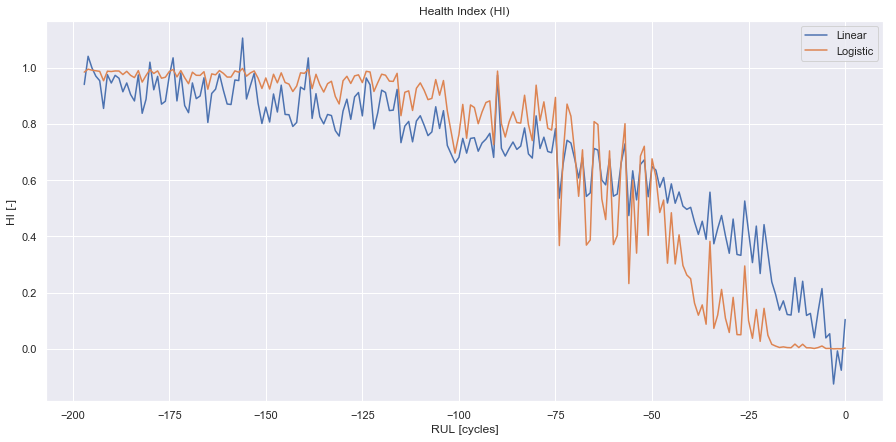

In [113]:
# let's see how this HI varies with RUL for a specific engine 

# get data for and engine
engine_num=50
engine_sensors=sensors_pca[engine_slices[engine_num],:]
RUL_engine = df.loc[engine_num]['RUL']

# predict the HI
HI_pred_lin = HI_linear.predict(engine_sensors)
HI_pred_log = HI_logistic.predict_proba(engine_sensors)[:,1]

# plot fused HI signal for linear and logistic models \
fig=plt.figure(figsize=(15,7))
plt.plot(RUL_engine,HI_pred_lin,label='Linear')
plt.plot(RUL_engine,HI_pred_log,label='Logistic')
plt.title('Health Index (HI)')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend();




In [114]:
fig.savefig('Meduim_images/HI_Log_Lin.png', format='png', dpi=600)

#### play with smootihg for testing data leter on

In [115]:
# exponential smoothing
exp_smooth =ExponentialSmoothing(HI_pred_lin,trend='add')
exp_smooth.fit();
Holt=HoltWintersResults(exp_smooth,exp_smooth.params)
y_exp=Holt.predict(0,len(HI_pred_lin)-1)

In [116]:
# find odd window length for filtering
percent_n_smaple = 0.15
temp_window = int(len(HI_pred_lin)*percent_n_smaple)
if temp_window %2 ==0:
    window = temp_window-1
else:
    window= temp_window
    
# apply savgol_filter to the signal
y_filter = savgol_filter(HI_pred_lin, window_length=window,polyorder=3)

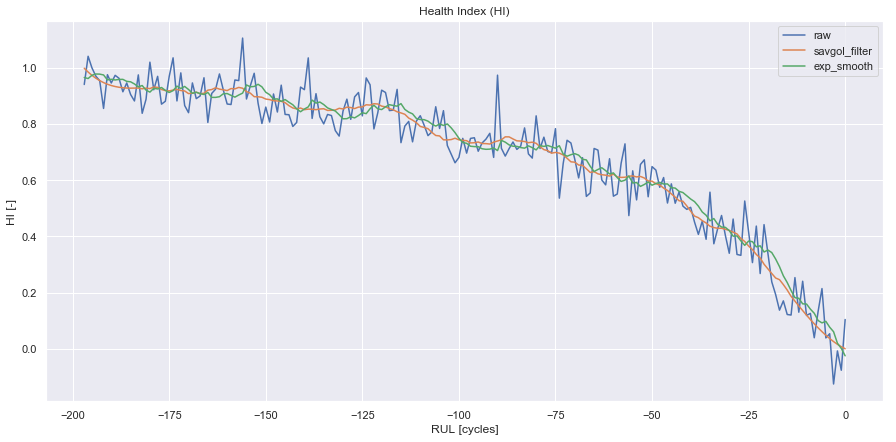

In [117]:
# plot fused HI signal with the smoothed signals

fig=plt.figure(figsize=(15,7))
plt.plot(RUL_engine,HI_pred_lin,label='raw')
plt.plot(RUL_engine,y_filter,label='savgol_filter')
plt.plot(RUL_engine,y_exp ,label='exp_smooth')
plt.title('Health Index (HI)')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend();


In [118]:
fig.savefig('Meduim_images/HI_Lin_smooth.png', format='png', dpi=600)

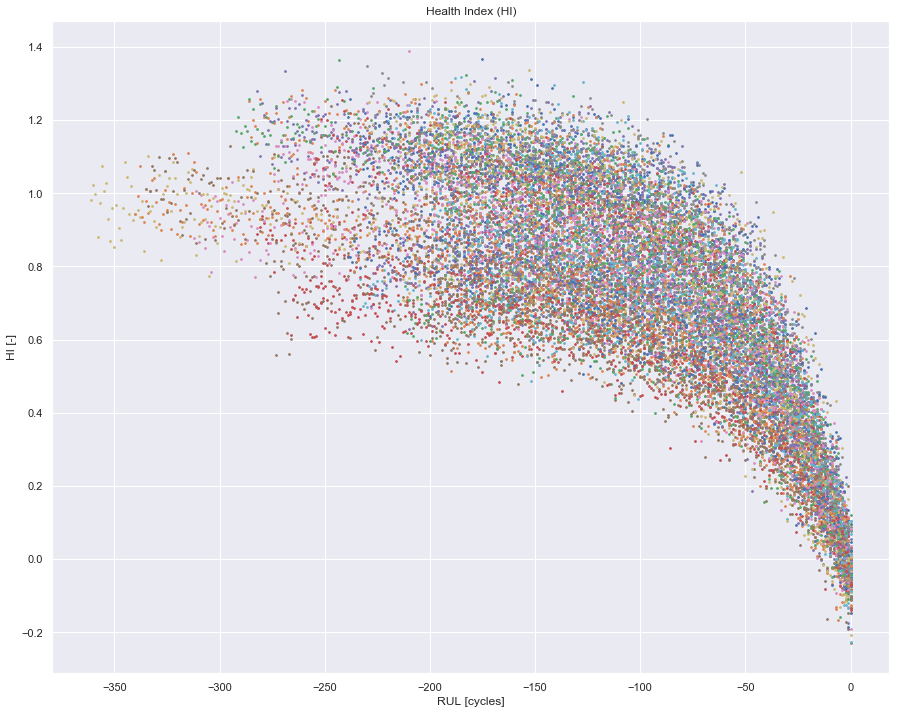

In [119]:
# plot HI for all engines 
fig=plt.figure(figsize=(15,12))
for engine_num in engines:
    
    engine_sensors=sensors_pca[engine_slices[engine_num],:]
    RUL_engine = df.loc[engine_num]['RUL']

    # predict the HI
    HI_pred_lin = HI_linear.predict(engine_sensors)
#     HI_pred_log = HI_logistic.predict_proba(engine_sensors)[:,1]

    
    plt.scatter(RUL_engine,HI_pred_lin,label=engine_num,s=3)
#     plt.scatter(RUL_engine,HI_pred_log,label='Logistic')
    plt.title('Health Index (HI)')
    plt.xlabel('RUL [cycles]')
    plt.ylabel('HI [-]')
#     plt.legend();



In [120]:
fig.savefig('Meduim_images/HI_all.png', format='png', dpi=600)

### curve fit the  Health Index (HI) with exponential function 

In [121]:
def exp_func(x, a, b):
    return a * (np.exp(b * x)-1)

In [122]:
# row of all the health index for all engines
HI_linear_df = HI_linear.predict(sensors_pca) 

In [123]:
# prepare sample data for fitting function 
engine_num=87
engine_idx=engine_slices[engine_num]
xdata=RUL_df[engine_idx]
y = HI_linear_df[engine_idx]

In [124]:
popt,_ = curve_fit(exp_func, xdata, y)

### plot HI [ raw , smoothed, exponential fitting] 

In [125]:
# find odd window length for filtering
percent_n_smaple = 0.15
temp_window = int(len(y)*percent_n_smaple)
if temp_window %2 ==0:
    window = temp_window-1
else:
    window= temp_window
    
# apply savgol_filter to the signal
y_filter = savgol_filter(y, window_length=window,polyorder=3)

In [126]:
# compute the exponential model curve 

y_exp_model = exp_func(xdata, *popt)

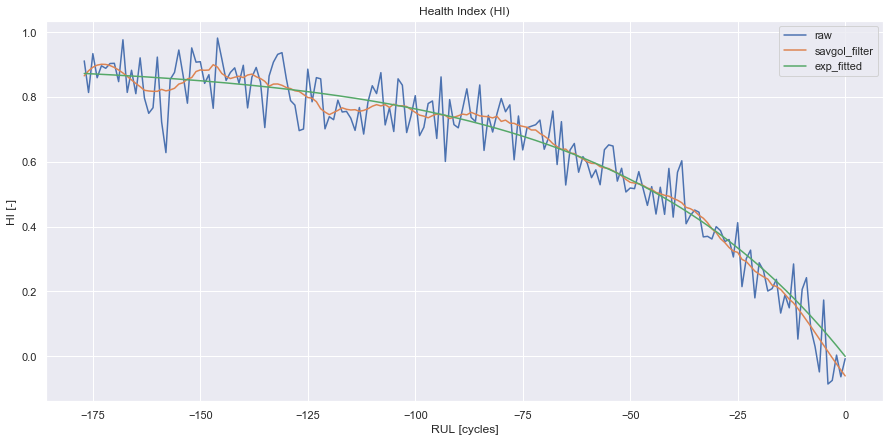

In [132]:
#  plot HI [ raw , smoothed, exponential fitting] 

fig=plt.figure(figsize=(15,7))
plt.plot(xdata,y,label='raw')
plt.plot(xdata,y_filter,label='savgol_filter')
plt.plot(xdata,y_exp_model ,label='exp_fitted')
plt.title('Health Index (HI)')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend();


In [133]:
fig.savefig('Meduim_images/exp_fitted.png', format='png', dpi=600)

### Create an exponential model for each engine [ these are used for similarity comparison later on testing]

In [128]:
def train_HI_param(df,sensors,fuse_model):
    
    """
    fits an exponential curve to the health index for each engine. 
    outputs the two parameters for exponential function (a,b)
    y = a*[exp(b*cycles) - 1] 
    ========================================================================
    
    input: 
    df- (df) data frame for the raw sensors  that left after transformation 
    sensors - (ndarray) normalize sensor to use for analysis and prediction of RUL 
    fuse_model - (sklearn) Sciket learn a trained model that fuse multi-dimensional sensors into a one-dimensional sensor  
    
    output: 
    exp_param -(ndarray) fitted parameters of the exponential function of each engine (num_eigines, 2) each row is [a,b]
    """
    
    # get indexes and slices that are useful to capture the raw data for a specific engine
    engines=df.index.unique().values # engine numbers
    engine_slices = dict()# key is engine number, value is a slice that gives numpy index for the data that pertains to an engine  
    
    # find engine_slices
    for i,engine_num in enumerate(engines):
        row_name=df.loc[engine_num].iloc[-1].name
        row_sl=df.index.get_loc(row_name) # row slice to get numpy index 
        engine_slices[engine_num]=row_sl
    
    # parameters for exponential HI model
    exp_param = np.empty((len(engines),2))

    # fit exp curve to each engine data
    for i,engine in enumerate(engines):
        engine_idx=engine_slices[engine]
        engine_cycles=RUL_df[engine_idx] # this is RUL ( negative integers and last cycle has value of 0)
        fused_sensor=fuse_model.predict(sensors[engine_idx,:])
        popt,_ = curve_fit(exp_func, engine_cycles,fused_sensor)

        exp_param[i,:] = popt

    
    return exp_param    

In [129]:
exp_param = train_HI_param(df,sensors_pca,HI_linear)

In [130]:
HI_linear_df.shape

(20631,)

In [131]:
# get the values of the fitted exp HI for all engines and put them in one array

HI_fitted_df = np.empty_like(HI_linear_df) 

for i,engine in enumerate(engines):
    engine_idx=engine_slices[engine]
    engine_cycles=RUL_df[engine_idx] # this is RUL ( negative integers and last cycle has value of 0)
    HI_fitted_df[engine_idx]=exp_func(engine_cycles,*exp_param[i,:])


**Summary of the training model above:**

the training model of the algorithm is just to find the health index(HI) for a given engine from its time series sensor. the training outcome is an exponential model that gives the HI for an engine as a function of its previous operating cycles ( its remain life RUL) 
the steps can be summarized as follows: 

1. after removing the sensors that have low variance or no definite trend toward the end of life among all engines, we will end up with a sensor data $\mathbf x\ = (x_1 , x_2 , ... , x_m)$ where $m$ is the number of sensors (columns) remaining after data cleaning 


2. normalize $\mathbf x\ $ using StandardScalar to get  $\mathbf x_{norm}\ $


3. find the linear trend (slope) of each $x_i$  with the RUL (engine operating cycles)


4. from $\mathbf x_{norm}\ $ , take a subset of $r$ sensors which have  $r$ highest absolute linear slope slope, the new subset is $\mathbf x_{slope}\ $


5. perform PCA on $\mathbf x_{slope}\ $ to  reduce dimensionally to space of $n$ columns. this last sensor subset is called  $\mathbf x_{pca}\ $




using  $\mathbf x_{pca}\ $, a linear model is used to fuse the $n$ sensors together to produce a one-dimensional sensor $y_{fused}$  notice

the linear model is obtained by taking a subset from $\mathbf x_{pca}\ $  which corresponds to the operational cycle larger than $RUL_{high}$ and smaller than $RUL_{min}$.  sensor values with cycles larger than $RUL_{high}$ gets mapped to 1 ( because they have a nearly perfect health) whereas sensor values with cycles smaller than $RUL_{min}$ get mapped to 0 since they almost have no remaining life. notice that the subset is taking from all engines so this fused model is a global model for the whole engine set. 


$y_{fused} = \mathbf \theta^T\ \mathbf x_{pca}\ + \theta_0$ 
where $\theta$ is the reustl of lienar regression model described above. 

now the sensor values for all engine at each engine cycle can be fused and converted to  $y_{fused}$ by applying the linear model. 

finally, the values obtained for  $y_{fused}$  for each engine is molded as an exponential curve that gives a model for the health index $HI$ as a function of engine cycles for all engine in the data set,



**predicting new engine RUL - lookahead process** 

what comes next is the algorithm for predicting RUL for a new engine based on sensor values that have operating cycles less than the full life-cycle. 

I'll use mainly interpolation scheme to compare the new engine $y_{fused}$ with the library of health index models just obtained from training. 

## Similarity comparison to get RUL for a new engine ( from a test set)

### Exprimentation to devalop RUL_predict function

In [134]:
# experiment with TimeSeriesSplit to prepare a synthetic testing engine 
engine_num=79

engine_idx = engine_slices[engine_num]

engine_cycles = RUL_df[engine_idx]

split_ts = TimeSeriesSplit(n_splits=3)

In [135]:
X = engine_cycles
y = HI_linear_df[engine_idx]
print('X has : {} cycles'.format(len(X)))
n=0
for train_index, test_index in split_ts.split(X):
    n=n+1
    percent = len(train_index)/len(X)
    print('Fold :{}'.format(n))
    print('X_train has : {} cycles'.format(len(train_index)))
    print('percentage of trainig cycles is {}'.format(percent))
    
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

X has : 199 cycles
Fold :1
X_train has : 52 cycles
percentage of trainig cycles is 0.2613065326633166
Fold :2
X_train has : 101 cycles
percentage of trainig cycles is 0.507537688442211
Fold :3
X_train has : 150 cycles
percentage of trainig cycles is 0.7537688442211056


In [136]:
# fused is like a new engine in which its sensor got transformed to a fused signal using the linear model
cycles = X[train_index] 
# fused = y[train_index]
fused = y[26:170]

In [137]:
# first smooth the data
def smooth_signal(sensor):
    """
    smooth the health index fused signal using savgol_filter
    ========================================================
    
    input: 
    sensor- (array) array with signal to be smothed 
    output:
    smooth -(array) same size as sensor and is the smoothed signal 
    """
    # find odd window length for filtering
    percent_n_smaple = 0.15
    temp_window = int(len(sensor)*percent_n_smaple)
    if temp_window %2 ==0:
        window = temp_window-1
    else:
        window= temp_window

    # apply savgol_filter to the signal
    smooth = savgol_filter(sensor, window_length=window,polyorder=3)
    return smooth



In [138]:
fused_smooth = smooth_signal(fused)

#### RUL_pool

In [139]:
def RUL_pool(fused_test,HI_lib,engine_slices):
    
    """
    finds RUL best estimate for each trained engine in the library
    ===============================================================
    
    input: 
    fused_test - (array) fused signal (HI) for a test engine 
    HI_lib -(array) health index values for each engine in our trained library
    engine_slices - (dict) key   : is engine number 
                           values: slices where each slice gives the indexes that can slice 
                           a specific engine data from HI_lib array
    output:
    RUL -(array) estimated  RUL for the test engine from each engine in the trained library length = len(engine_slices)
    SSD_min (array)
    total_life (array)

    """
    
    # initialize the output arrays
    RUL=np.empty(len(engine_slices))
    total_life = np.empty_like(RUL)
    SSD_min = np.empty_like(RUL)
    
    # smooth the test signal 
    fused_smooth = smooth_signal(fused_test)

    for i,engine in enumerate(engine_slices):
        HI_model = HI_lib[engine_slices[engine]] # HI model for an engine 
        
        # this if statement just in case if the training data is already shorter in cycles than the test data
        if len(fused_test)> len(HI_model):
            RUL[i]=0
            total_life[i]=len(fused_smooth)+RUL[i]
            SSD_min[i] = np.linalg.norm((fused_smooth[0:len(HI_model)] - HI_model))
            continue
            
        dist_sqr=euclidean_distances(fused_smooth.reshape(-1, 1),HI_model.reshape(-1, 1),squared=True)

        # cycle gap parameter that is part of similarity calcualtion 
        diff_cycle = len(HI_model)-len(fused_smooth)
        diag_offset = list(range(0,diff_cycle+1)) # cycle gap parameter values

        # find distance between the test engine curve and model curve (SSD) for every cycle gap parameter
        SSD=np.array([np.trace(dist_sqr,k) for k in  diag_offset]) # Sum of Squared Differences
        SSD_min[i] = SSD.min() # minimum Sum of Squared Differences (the similarity metric low means very similar)
        T0 =  SSD.argmin() # optimum cycle gap parameter

        RUL[i] = diff_cycle-T0
        total_life[i]=len(fused_smooth)+RUL[i]
    
    
    return RUL , SSD_min , total_life

In [140]:
RUL_pooled,SSD_min,total_life=RUL_pool(fused_smooth,HI_fitted_df,engine_slices)

#### Helper functions for RUL_predict

In [141]:
def RUL_similarity_filter(distance,max_distance=8,min_rows=12):
    
    """
    select top RUL candidate from RUL pool based on similarity scores
    ===============================================================
    
    input: 
    distance - (array) Sum of Squared Differences (distance) of the test HI from each engine HI model in the library 
    max_distance -(float) > 1 factor to select rows from 'distance' that satisfies: distance< 'max_distance' * min('distance')
    min_rows - (int) minimum RUL candidate to select from RUL pool 
    
    output:
    idx -(array) indexes of the selected 'distance'
    """
    
    # selects rows that have cutoff distance   set to a 'max_distance'*100% increase of the smallest score (d1)
    d1 = distance.min()
    idx = np.where(distance<max_distance*d1)[0]
    
    if len(idx)< min_rows:
        idx =np.argsort(distance)[0:min_rows]

    return idx

In [142]:
RUL_similarity_filter(SSD_min,max_distance=5.5,min_rows=12)

array([78, 14, 77, 32, 29, 58, 81,  9, 60, 46, 30,  8], dtype=int64)

In [143]:
def RUL_stat_filter(RUL_pooled,total_life,RUL_max=180,life_min=125):
    
    """
    filters RUL candidate from RUL pool based on statistical observation of the RUL distribution from all engines 
    ===========================================================================================================
    
    input: 
    RUL_pooled - (array) estimated RUL for the test engine from each engine in the library 
    total_life -(array)  estimated  total life for the test engine from each engine in the library
    RUL_max- (int)    : maximum RUL above which I consider the prediction large (since probably extrapolate too much in future)- based on roughly the mean of RUL distribution 
    life_min - (int) minimum life of test engine. This comes from RUL distribution obtained from training set
    
    output:
    idx -(array) indexes of the selected rows of 'RUL_pooled'
    """
    idx1 = np.where(RUL_pooled<=RUL_max)[0]
    idx2 = np.where(total_life>=life_min)[0]
    idx  = np.intersect1d(idx1,idx2)
    
    return idx

In [144]:
np.floor(np.median(RUL_stat_filter(RUL_pooled,total_life,RUL_max=110,life_min=125)+.66))

45.0

In [145]:
((1.0/SSD_min).T @ RUL_pooled)/(1.0/SSD_min).sum()

33.03199028813248

### RUL_predict function

In [146]:
def RUL_predict(RUL_pooled,distance,total_life,method=1,max_distance=8,min_rows=12,RUL_max=180,life_min=125):
    
    """
    fuse multiple RUL estimate from all engines into the final prediction RUL of a testunit 
    ===========================================================================================================
    
    input: 
    RUL_pooled - (array) estimated RUL for the test engine from each engine in the library 
    distance - (array) Sum of Squared Differences (distance) of the test HI from each engine HI model in the library 
    total_life -(array)  estimated  total life for the test engine from each engine in the library
    method - (int) flag to determine which method to use to fuse multiple RUL predictions
    
                    method = 1, final_RUL = median of values 
                    method = 2, final_RUL = weighted mean of values weights based on similarity score 
                    method = 3, final_RUL = weighted mean of max and min two values weights based on PHM score
                    method = 4, final_RUL = mean of values
                    
    RUL_max- (int)    : maximum RUL above which I consider the prediction large (since probably extrapolate too much in future)- based on roughly the mean of RUL distribution 
    life_min - (int) minimum life of test engine. This comes from RUL distribution obtained from training set
    max_distance -(float) > 1 factor to select rows from 'distance' that satisfies: distance< 'max_distance' * min('distance')
    min_rows - (int) minimum RUL candidate to select from RUL pool

    output:
    final_RUL -(int) final predicted RUL for a test unit
    """
    # filter RUL_pooled based on similarity score 
    similarity_filter_idx=RUL_similarity_filter(distance,max_distance,min_rows)
    final_RUL = RUL_pooled[similarity_filter_idx]
    final_distance = distance[similarity_filter_idx]
    final_total_life = total_life[similarity_filter_idx]
    
    # filter final_RUL based on stat_filter
    stat_filter_idx=RUL_stat_filter(final_RUL,final_total_life,RUL_max,life_min)
    final_RUL = final_RUL[stat_filter_idx]
    final_distance = final_distance[stat_filter_idx]
    final_total_life = final_total_life[stat_filter_idx]
    
    # fusing final_RUL:
    
    if method==1: # median
        final_RUL=np.floor(np.median(final_RUL))
        
    elif method==2: # weighted mean based on distance
        w = 1./final_distance # weights
        sum_w=w.sum()
        final_RUL=(w.T @ final_RUL)/sum_w
        final_RUL=np.floor(final_RUL)
            
    elif method==3: # mean of max and min
        w = np.array([13.0,10.0 ]) # weights
        sum_w=w.sum()
        final_RUL=np.array([final_RUL.min(),final_RUL.max()])
        final_RUL=(w.T @ final_RUL)/sum_w
        final_RUL=np.floor(final_RUL)
    else: # simple mean
        final_RUL=np.floor(final_RUL.mean())
            
            
    
    return final_RUL

### Score function

In [147]:
def penalty_score(estimated_RUL,true_RUL):
    
    """
    computes penalty score of RUL prediction (main metric of the algorithm) 
    ===========================================================================================================
    
    input: 
    estimated_RUL - (float/array) estimated RUL for the test engine  
    true_RUL - (float/array) true RUL for the test engine  

    output:
    S -(float/array) asymmetric penalty score of the algorithm  
    
    """
    error = np.array(estimated_RUL)-np.array(true_RUL)
    error = np.array(error)
    S1 = np.heaviside(error,0)* (np.exp(error/10)-1) # postive errors
    S2 = np.heaviside(-1*error,0)* (np.exp(-1*error/13)-1) # negative errors
    S = S1 + S2 

    return S

In [148]:
# experiment RUL_predict

# get data and keep a certian percentage [ simulate a testing engine]
engine_num=79
engine_idx = engine_slices[engine_num]
y = HI_linear_df[engine_idx] # full data 
percent = .9 # percentage to keep
last_cycle=np.floor(len(y)*percent)
true_RUL = len(y)-last_cycle # current true RUL for truncated data

# test data
y_test = y[0:int(last_cycle)]

# smooth the test data
y_test_smooth = smooth_signal(y_test)
# y_test_smooth = y_test

# get pooled estiamte from model
RUL_pooled,distance,total_life=RUL_pool(y_test_smooth,HI_fitted_df,engine_slices)



In [149]:
# model out 
estimated_RUL=RUL_predict(RUL_pooled,distance,total_life,method=2)

In [150]:
error = estimated_RUL-true_RUL
error

2.0

In [151]:
estimated_RUL

22.0

In [152]:
true_RUL

20.0

In [153]:
penalty_score(estimated_RUL,true_RUL)

0.22140275816016985



**Inputs:**

the prediction of new engine RUL takes as input:
1. a fused sensor with observation equals the current life cycle for the new engine
2. fitted exponential model of the HI for all trained engines 

**Find/compare similarity** 
the model then tries to compare the observation of the fused sensor for the new engine with the HI models (exponential fitted curves) in the model library from the training stage. 
1. basically, the model finds the sum of squared differences (SSD) between the fused sensor and each fitted model in the library and defines this SSD as the similarity measure between the fused sensor and each engine model in the library.
2. since normally the new engine fused sensor total observations (M) which are less than the model library engine observations (Ti), the model also shifts the fused sensor curves with time (by cycle gap parameter) to find several SSD for each engine model. the number of SSD per training engine depends on the difference between the fused sensor and training engine observations (Ti - M)
3. the minimum of SSD from each training engine along with the respective estimated RUL for the new engine is obtained. 
4. the model now has N estimated RUL and associated N SSD that need to be fused to give the final RUL for the test engine. N here is the total number of engines in the training set

**RUL fusion and final model output:**

the N estimated RUL are reduced to N_red RUL. the reduction happens by eliminating RUL predicted from engine  model with high SSD ( low similarity) and by consideration related to the statistics on the training set (simple outlier removal)

N_red RUL then gets fused into one RUL which is the model ultimate output.

the way to do this is by using a weighted average of the N_red RUL or taking the median  (Method 1) of RUL. three different weightings are used here: 

1. weighted average based on SSD, higher weights for low SSD  (Method 2)
2. min max weighted where only the maximum and minimum RUL out of N_red are weighted together using higher weight for the low RUL since it is more conservative and this is preferable  (Method 3)
3. simple arithmetic mean, where all weights are equaled Method 4)


# <font color='blue'>Refinement</font>

**the effect of various method to fuse the estimated RUL is investigated here on the training set to see which method gives best results. also, smoothing the data before making the estimation is investigated. truncated data with various length is used to see the algorithm robustness**

In [154]:
def model_performance(HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=1,smooth=True):
    
    """
    evaluates the penalty score by truncating the training data for all engines by various amounts.
    this allows testing the method and smooth parameters of the algorithm for refinement on the algorithm.   
    ========================================================================
    
    input: 
    HI_linear_df- (array)  
    HI_fitted_df - (array) 
    engine_slices - (dict)
    engines - (list) engine numebrs
    percents - (list) list of percentage values of how much to keep from original data (simulated testing data)
    methods - (int) [1,2,3,4]
    smooth-(bool)
    
    output: 
    scores -(ndarray) penalty score for all combinations of percentages and engines 
    errors -(ndarray) errors for all combinations of percentages and engines 
    """
    # initilize the scores and errors 
    n_engines = len(engines)
    n_percents = len(percents)
    scores = np.empty((n_engines,n_percents))
    errors = np.empty_like(scores)
    
    # loop through all engines in training set
    for i,engine in enumerate(engines):
        engine_idx=engine_slices[engine]

        # get data and keep a certian percentage [ simulate a testing engine]
        y = HI_linear_df[engine_idx] # full data 
        
        # loop through each percentage value
        for j,percent in enumerate(percents):
            last_cycle=np.floor(len(y)*percent)
            true_RUL = len(y)-last_cycle # current true RUL for truncated data

            # test data
            y_test = y[0:int(last_cycle)]

            # smooth the test data
            if smooth:
                y_test = smooth_signal(y_test)
                
            # get RUL estiamte and error
            RUL_pooled,distance,total_life=RUL_pool(y_test,HI_fitted_df,engine_slices)
            estimated_RUL=RUL_predict(RUL_pooled,distance,total_life,method=methods)
            error = estimated_RUL-true_RUL
            
            # penalty score
            score=penalty_score(estimated_RUL,true_RUL)
            
            # fill the outputs
            scores[i,j] = score
            errors[i,j] = error





    
    return scores, errors    

## Method 1  Refinement

In [155]:
method = 1
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 1 
method1_score_sm,method1_error_sm=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

smooth = False
# smooth method 1 
method1_score,method1_error=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

## Method 2  Refinement

In [156]:
method = 2
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 2 
method2_score_sm,method2_error_sm=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

smooth = False
# smooth method 2 
method2_score,method2_error=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

## Method 3  Refinement

In [157]:
method = 3
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 3 
method3_score_sm,method3_error_sm=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

smooth = False
# smooth method 3 
method3_score,method3_error=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

## Method 4  Refinement

In [158]:
method = 4
percents = [.5,.6,.7,.8,.9]
smooth = True
# smooth method 4 
method4_score_sm,method4_error_sm=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

smooth = False
# smooth method 4 
method4_score,method4_error=model_performance(
    HI_linear_df,HI_fitted_df,engine_slices,engines,percents,methods=method ,smooth=smooth)

In [159]:
method1_score_sm.sum(axis=0)

array([31174.30859988,  4689.63661667,  8170.42502777,  1164.1195178 ,
         269.22634327])

In [160]:
method2_score_sm.sum(axis=0)

array([665.28589553, 430.63595206, 455.76238185, 240.60007463,
       113.93351143])

In [161]:
method1_score.sum(axis=0)

array([31358.34277409,  4710.7234809 ,  7946.86880287,  1139.29000527,
         271.19546496])

### Method 1 smooth / no-smooth comapre

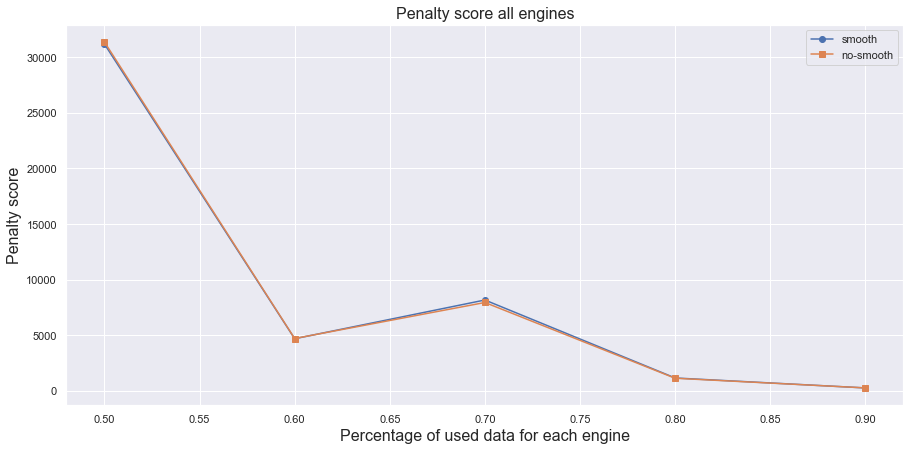

In [162]:
fig=plt.figure(figsize=(15,7))

plt.plot(percents,method1_score_sm.sum(axis=0),'-o',label='smooth')
plt.plot(percents,method1_score.sum(axis=0),'-s',label='no-smooth')
plt.title('Penalty score all engines',{'fontsize':16});
plt.ylabel('Penalty score',{'fontsize':16});
plt.xlabel('Percentage of used data for each engine',{'fontsize':16});
plt.legend()
plt.show()
# ax = sns.boxplot( data=RUL)
# ax = sns.swarmplot( data=RUL, color=".25")

## All Methods comapre smooth = True

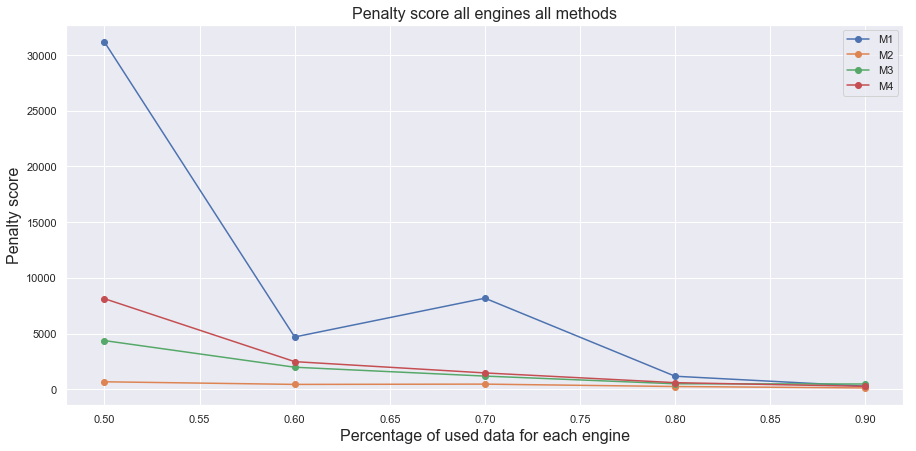

In [166]:
fig=plt.figure(figsize=(15,7))

plt.plot(percents,method1_score_sm.sum(axis=0),'-o',label='M1')
plt.plot(percents,method2_score_sm.sum(axis=0),'-o',label='M2')
plt.plot(percents,method3_score_sm.sum(axis=0),'-o',label='M3')
plt.plot(percents,method4_score_sm.sum(axis=0),'-o',label='M4')
plt.title('Penalty score all engines all methods',{'fontsize':16});
plt.ylabel('Penalty score',{'fontsize':16});
plt.xlabel('Percentage of used data for each engine',{'fontsize':16});
plt.legend()
plt.show()
# ax = sns.boxplot( data=RUL)
# ax = sns.swarmplot( data=RUL, color=".25")

In [167]:
fig.savefig('Meduim_images/Performance.png', format='png', dpi=600)

## Method 2 smooth / no smooth compare

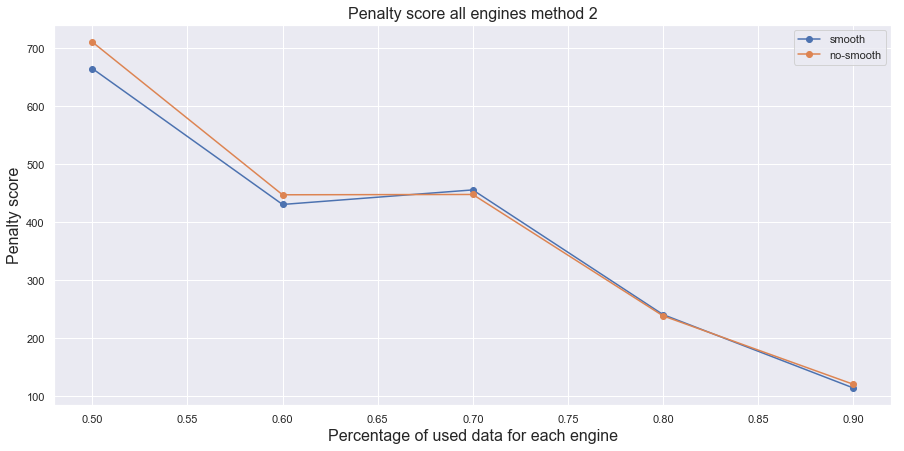

In [164]:
fig=plt.figure(figsize=(15,7))

plt.plot(percents,method2_score_sm.sum(axis=0),'-o',label='smooth')
plt.plot(percents,method2_score.sum(axis=0),'-o',label='no-smooth')
plt.title('Penalty score all engines method 2',{'fontsize':16});
plt.ylabel('Penalty score',{'fontsize':16});
plt.xlabel('Percentage of used data for each engine',{'fontsize':16});
plt.legend()
plt.show()
# ax = sns.boxplot( data=RUL)
# ax = sns.swarmplot( data=RUL, color=".25")

In [165]:
fig.savefig('Meduim_images/Method 2 smooth  no smooth compared.png', format='png', dpi=600)

## Summary of the process of predicting RUL for a new engine

# <font color='blue'>Model Evaluation and Validation</font>

from the above figures showing the penalty score (lower values for penalty score are better in terms of accuracy) versus the percentage of the observation from total data for the four different methods, we can make the following comments on the final model performance to new engine data: 
1. Method 2 ( fusing RUL based on SSD weighted average) is the best in terms of penalty score. the method performs exceptionally great even from a low percentage of used data ( i.e. predicting more in future)
2. all methods seem to be very similar when the percentage of used data is high, i.e. when the test engine current operation cycles are close to the total life of the engine. this is expected since predicting for few cycles in the future is easier and extrapolating for large cycles into the futures. 
3. smoothing the test data before feeding it to the model seems to have very little effect. however, smoothing the data gives a better score for all methods and percentages.

# <font color='blue'>Reflection</font>

**Summary of the end-to-end problem solution:**

**problem:**

given run to failure measurements of various sensors on a sample of similar jet engines, estimate the remaining useful life (RUL) of a new jet engine that has measurements of the same sensor for a period of time equal to its current operational time. 

**solution:**

1. for each run to failure measurements, take sensors that have a predictable, high trend toward the end life cycles

2. using these sensors, make a model that will fuse these sensors to give a virtual one-dimensional health index (HI) that varies from roughly 1 at begging of cycles up to 0 near the end-life. 

3. model and store these HI for each available run to failure engine and call HI the "model" 

4. using new engine measurements, fuse its measurements to make a fused HI.

5. compare this HI with the HI models exist in the model library 

6. find RUL of the new engine based on RUL of the model engines. 



# <font color='blue'>Improvement</font>

**Code structure improvement** 

1. creation of a transform pipeline that takes the input sensor and gives as the output the fused HI sensor 
2. create/inherent sklearn estimator and make the fitting and prediction methods here into one estimator for ease of use and for the purpose of using proper cross-validation for 
3. make the selection of sensors an automatic process based on condition internal to the data


**Algorithm improvement**

1. use different than a linear regression model to fuse the sensors
2. instead of cooking-up a one-dimensional health index, using impending or Neural Network Models that are trained directly to predict RUL based on input sensor measurements. this option seems promising and should give better accuracy, but requires more computational resosrse, but eliminates the feature engineering process and could generalize better
3. use cross-validation to select various model parameters instead of using heuristics. these improvements need to crate custom estimator and custom transformer first 

# <font color='blue'>Acknowledgment</font>

the analysis made here is motived mainly by: 

1. T. Wang, J. Yu, D. Siegel, J. Lee, "A similarity-based prognostics approach for remaining useful life estimation of engineered systems", Proc. Int. Conf. Prognostics Health Manage., pp. 1-6, Oct. 2008.

2. Similarity-Based Remaining Useful Life Estimation: https://www.mathworks.com/help/predmaint/examples/similarity-based-remaining-useful-life-estimation.html#SimilarityBasedRULExample-10 
